In [27]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Input
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [10]:
df = pd.read_csv('./data/unprocessed/tripadvisor_hotel_reviews.csv')
df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


In [11]:
class_distribution = df['Rating'].value_counts()
print(class_distribution)

Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64


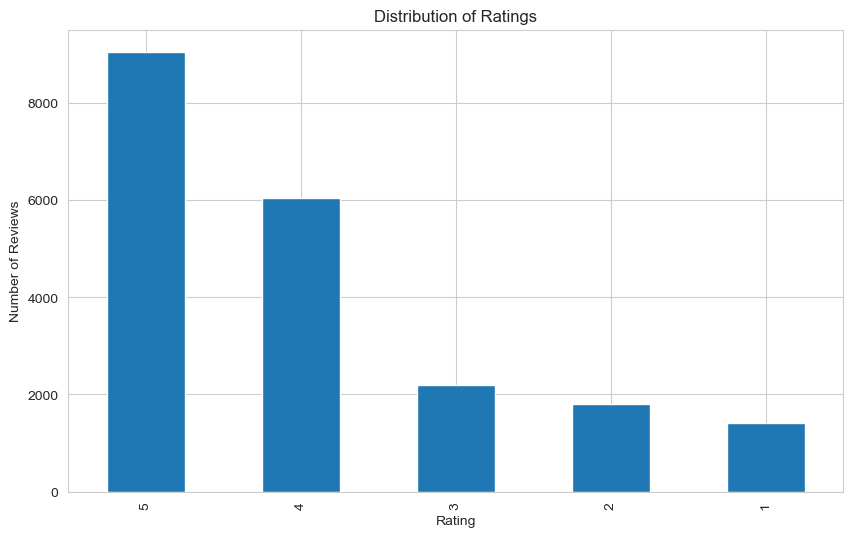

In [12]:
sns.set_style("whitegrid")

# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['Review'])

#90% of sequences are around 200.
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post')
max_seq_length = 200

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['Rating'], test_size=0.3, random_state=22)

#fit the model [0,5)
y_train -= 1
y_test -= 1

In [18]:
# Check distribution in the training set
print(y_train.value_counts(normalize=True))

# Check distribution in the testing set
print(y_test.value_counts(normalize=True))

Rating
4    0.442237
3    0.295754
2    0.106742
1    0.086035
0    0.069232
Name: proportion, dtype: float64
Rating
4    0.440956
3    0.292290
2    0.106213
1    0.090924
0    0.069616
Name: proportion, dtype: float64


PostNorm

In [35]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), 
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

PreNorm

In [23]:
class TransformerBlockPreNorm(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),])
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # Apply LayerNorm before the attention
        norm1 = self.layernorm1(inputs)
        attn_output = self.att(norm1, norm1)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output  # Skip connection
        
        # Apply LayerNorm before the FFN
        norm2 = self.layernorm2(out1)
        ffn_output = self.ffn(norm2)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output 
    



PostNorm only after FFN

In [24]:
class TransformerBlockPostFFNN(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm = LayerNormalization(epsilon=1e-6)  # Only one LayerNorm after FFN
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output  # Skip connection after attention
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # Apply LayerNorm only after FFN
        return self.layernorm(out1 + ffn_output)

In [25]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [37]:
#set up to build model
def create_transformer_model(
    num_blocks=1,
    embed_dim=32, 
    num_heads=2, 
    ff_dim=32, 
    num_classes=5
):
    inputs = Input(shape=(max_seq_length,))
    embedding_layer = TokenAndPositionEmbedding(max_seq_length, vocab_size, embed_dim)
    
    x = embedding_layer(inputs)
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(20, activation="relu")(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = create_transformer_model()
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [38]:
history = model.fit(X_train, y_train, 
                    batch_size=10, epochs=5, 
                    validation_data=(X_test, y_test)
                   )

Epoch 1/5
1640/1640 [==============================] - 14s 8ms/step - loss: 1.0224 - accuracy: 0.5541 - val_loss: 0.8517 - val_accuracy: 0.6125
Epoch 2/5
1640/1640 [==============================] - 12s 8ms/step - loss: 0.7256 - accuracy: 0.6910 - val_loss: 0.8710 - val_accuracy: 0.6284
Epoch 3/5
1640/1640 [==============================] - 13s 8ms/step - loss: 0.5562 - accuracy: 0.7698 - val_loss: 1.0194 - val_accuracy: 0.6076
Epoch 4/5
1640/1640 [==============================] - 13s 8ms/step - loss: 0.4045 - accuracy: 0.8444 - val_loss: 1.2906 - val_accuracy: 0.5976
Epoch 5/5
1640/1640 [==============================] - 13s 8ms/step - loss: 0.2916 - accuracy: 0.8954 - val_loss: 1.5021 - val_accuracy: 0.5710


In [40]:
mock_reviews = pd.Series(
    [ 
        "Good stuff",
        "Bad stuff",
        "surely the first choice for visitors who expect to be served in luxury way",
        #rating 5
        "One of the nicest hotels I have ever stayed in. The property is simply beautiful and the history within its walls is quite incredible. What really makes the property special is the staff. They are incredible and nothing is too much trouble. The service is completely attentive without being obtrusive and makes one feel completely at home and also very special. A special mention to Irshad, Himmat, Fazal, Anil, Amit and Vishal. Irshad and Himmat were particularly helpful and helped to arrange a very special celebration for my daughter’s birthday. A mention also for Pradeep Kumar, Director of F&B who ensured all of our restaurant experiences were impeccable. I cannot recommend the hotel enough and cannot wait to return.",
        #rating 5
        "I booked a Harbor View Room for two nights, When I arrived jet lagged I was told that I had broke a Chinese Sea View room and that the room I thought I had was not available. But I could upgrade to have the view I wanted. Unfortunately the print out I had with me was just the welcoming email and not the actual booking confirmation. And I couldn't find the email quickly on my phone after 24+h travel so I relented and thought something went wrong on my office's end and did the upgrade.Turns out when I got the booking confirmation that I had indeed booked the right room category, which I was denied on checkin. I wonder if there is some money making scheme at play here from the hotel, contacted them so will find out I guess but so far beware. I did not expect this from a Ritz. Room sure was nice and service great but this is concerning.",
        #ratting 2
        "Worse Service, Not be respected and non-professional treatment.",
        #rating 1
        "Great experience and worthy of it’s stars! I highly recommend as the goto place for those special events and occasion’s!"
        #rating 5
    ]
)
def predict_rating(review):
    x_review_seq = tokenizer.texts_to_sequences([review])
    x_review_padded = pad_sequences(x_review_seq, maxlen=max_seq_length, padding='post')
    prediction = model.predict(x_review_padded)
    
    rating = 0
    for i, score in enumerate(prediction[0]):
        rating += (i + 1) * score

    print(f"Review: {review}\nPredicted Rating: {round(rating, 2)}\n")
    

for review in mock_reviews:
    predict_rating(review)



1/1 [==============================] - 0s 13ms/step
Review: Good stuff
Predicted Rating: 3.74

1/1 [==============================] - 0s 14ms/step
Review: Bad stuff
Predicted Rating: 2.94

1/1 [==============================] - 0s 12ms/step
Review: surely the first choice for visitors who expect to be served in luxury way
Predicted Rating: 4.54

1/1 [==============================] - 0s 12ms/step
Review: One of the nicest hotels I have ever stayed in. The property is simply beautiful and the history within its walls is quite incredible. What really makes the property special is the staff. They are incredible and nothing is too much trouble. The service is completely attentive without being obtrusive and makes one feel completely at home and also very special. A special mention to Irshad, Himmat, Fazal, Anil, Amit and Vishal. Irshad and Himmat were particularly helpful and helped to arrange a very special celebration for my daughter’s birthday. A mention also for Pradeep Kumar, Director

In [32]:
from matplotlib import pyplot as plt
#Implement 5 fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=22)
fold_no = 1
history_scores = {}

for train_index, test_index in kf.split(padded_sequences):
    X_train, X_test = padded_sequences[train_index], padded_sequences[test_index]
    y_train, y_test = df['Rating'].iloc[train_index], df['Rating'].iloc[test_index]
    
    y_train -= 1
    y_test -= 1
    
    model = create_transformer_model()
    model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
    )
    
    # Store the results of model.fit()
    history = model.fit(
    X_train, 
    y_train, 
    batch_size=16, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    )
    
    # Store history in a dictionary
    history_scores['fold_' + str(fold_no)] = history.history
    
    # Increase the fold number
    fold_no += 1

Epoch 1/10
1025/1025 [==============================] - 11s 10ms/step - loss: 1.3292 - accuracy: 0.4449 - val_loss: 1.2554 - val_accuracy: 0.4489
Epoch 2/10
1025/1025 [==============================] - 10s 10ms/step - loss: 1.0476 - accuracy: 0.5409 - val_loss: 0.9658 - val_accuracy: 0.5655
Epoch 3/10
1025/1025 [==============================] - 11s 10ms/step - loss: 0.8386 - accuracy: 0.6316 - val_loss: 0.9212 - val_accuracy: 0.5799
Epoch 4/10
1025/1025 [==============================] - 11s 11ms/step - loss: 0.7321 - accuracy: 0.6906 - val_loss: 0.9044 - val_accuracy: 0.5926
Epoch 5/10
1025/1025 [==============================] - 11s 11ms/step - loss: 0.6426 - accuracy: 0.7369 - val_loss: 0.9041 - val_accuracy: 0.6077
Epoch 6/10
1025/1025 [==============================] - 11s 10ms/step - loss: 0.5599 - accuracy: 0.7815 - val_loss: 0.9772 - val_accuracy: 0.5977
Epoch 7/10
1025/1025 [==============================] - 11s 11ms/step - loss: 0.4883 - accuracy: 0.8158 - val_loss: 1.0743 -

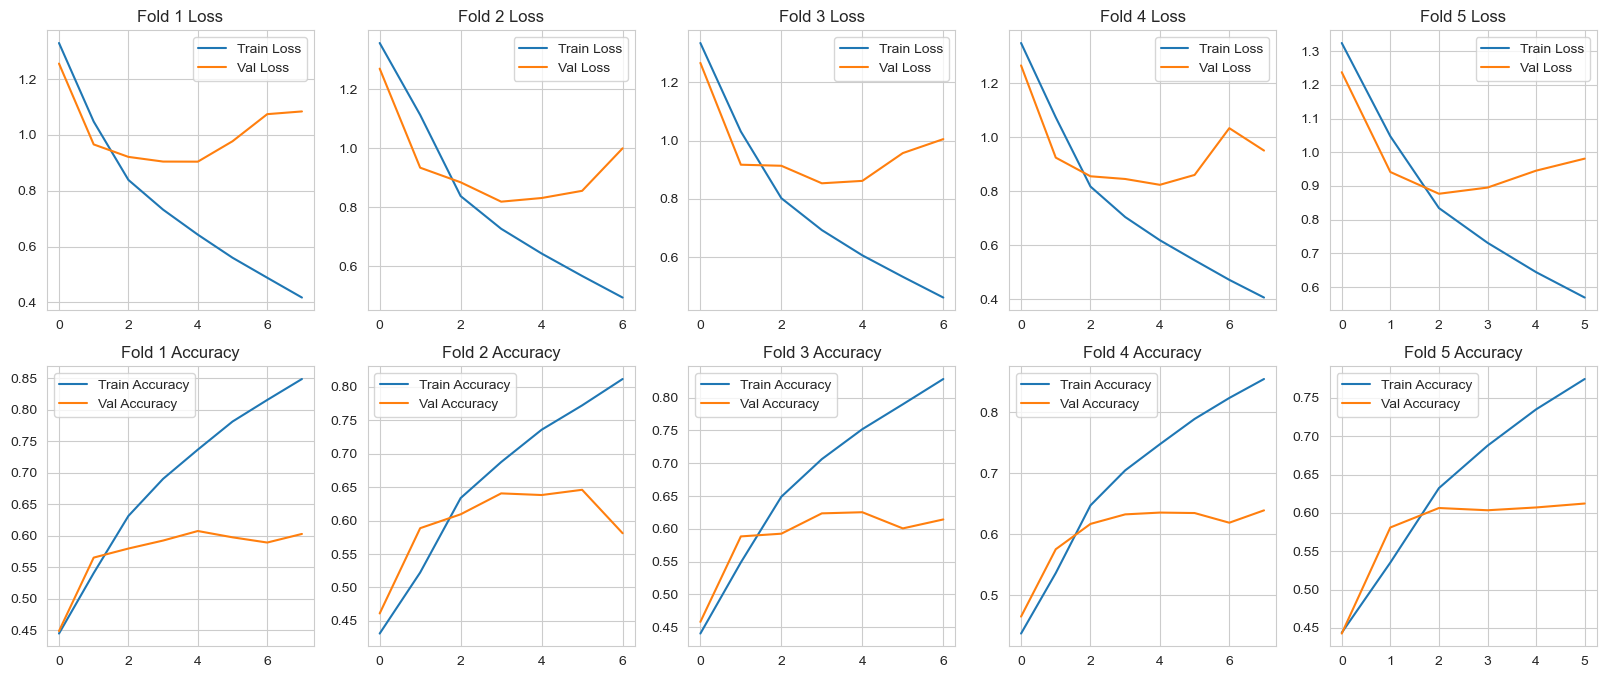

In [33]:
# After the cross-validation loop, plot the results
fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # Adjust the figure size as necessary

for i, (key, history) in enumerate(history_scores.items()):
    # Plot training loss
    axs[0, i].plot(history['loss'], label='Train Loss')
    axs[0, i].plot(history['val_loss'], label='Val Loss')
    axs[0, i].set_title(f'Fold {i+1} Loss')
    axs[0, i].legend()

    # Plot training accuracy
    axs[1, i].plot(history['accuracy'], label='Train Accuracy')
    axs[1, i].plot(history['val_accuracy'], label='Val Accuracy')
    axs[1, i].set_title(f'Fold {i+1} Accuracy')
    axs[1, i].legend()

# Display the plots
plt.show()